In [28]:
import os, sys
import pickle
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model as load_keras_model 
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from dataset import Dataset
from database import Database
from sample import Sample

class NeuralNetworkDetector(Database):
    
    __scaler = None
    __model = None
    __history = None
    __input_shape = None
    def __init__(self, dataset_location, database_location, site, transforms, transforms_params):
        self.__transforms = transforms
        self.__transforms_params = transforms_params
        super().__init__(dataset_location, database_location, site)
    
    ################
    """SAVE AND LOAD MODEL"""
    def save_scaler(self, scaler, name=''):
        """Save the scaler used to scale the training data
        Param
            scaler: scaler object
            name: additional name
        """
        print('Saving scaler .... ',end='')
        standard_scaler = {"scaler": scaler}
        scaler_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_scaler.pickle')
        pickle.dump( standard_scaler, open(scaler_path, "wb" ) )
        print('Done.')

    def save_history(self, history, name=''):
        """Save the history from the training
        Param
            history: dictionary object
            name: additional name
        """
        print('Saving history .... ',end='')
        history = {"history": history.history}
        history_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_history.pickle')
        pickle.dump( history, open(history_path, "wb" ) )
        print('Done.')
        
    def save_model(self, model, name=''):
        """Save the trained model
        Param
            model: model object
            name: additional name
        """
        print('Saving history .... ',end='')
        model_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_model.h5')
        model.save(model_path)
        print('Done.')
        
    def load_scaler(self, name=''):
        """Load scaler
        Param
            name: additional name
        """
        scaler_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_scaler.pickle')
        scaler = pickle.load( open( scaler_path, "rb" ) )['scaler']
        self.__scaler = scaler
        return scaler
    
    def load_history(self, name=''):
        """Load the history
        Param
            name: additional name
        """
        history_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_history.pickle')
        history = pickle.load( open( history_path, "rb" ) )['history']
        self.__history = history
        return history
    
    def load_model(self, name=''):
        """Load the trained model
        Param
            name: additional name
        """
        model_path = os.path.join(self.get_database_location(),self.get_site(),'models',
                                   name+'_'+str(self.__transforms)+'_'+str(self.__transforms_params)+'_model.h5')
        model = load_keras_model(model_path)
        self.__model = model
        return model

    #########################
    """MODEL VISUALISATION"""
    def get_conv_layers(self, model):
        """Get number of convolutional layers in the model
        """
        layers = []
        # summarize filter shapes
        for layer in model.layers:
            # check for convolutional layer
            if 'conv' not in layer.name:
                continue
            # get filter weights
            layers.append(layer)
        return layers

    def visualization(self, model, conv_layer_number=0,figsize=None):
        '''Visualize the CNN model'''
#         if summary:
#             print(model.summary())
#         if plot:
#             path = os.path.join(database_loc,site,'models','model.png')
#             plot_model(model, show_shapes=True, show_layer_names=True, to_file=path)
#             Image(retina=True, filename=path)
        # get filers and biases
        filters, biases = self.get_conv_layers(model)[conv_layer_number].get_weights()
        # scale filters
        f_min, f_max = filters.min(), filters.max()
        filters = (filters-f_min)/(f_max-f_min)
        # get number of filters
        n_filters, ix = filters.shape[-1], 1
        plt.figure(figsize=figsize)
        for i in range(n_filters):
            # get the filters
            f = filters[:,:,:,i]
            # plot each channel seperately
            for j in range(1):
                # specify subplot and turn of axis
                ax = plt.subplot(1,n_filters, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.pcolormesh(f[:, :, j], cmap='gray')
                ix += 1
        plt.show()

    def visualization_fm(self, model,train_X, conv_layer_number=0):
        data = train_X[np.random.randint(len(train_X))]# get filers and biases
        filters, biases = self.get_conv_layers(model)[conv_layer_number].get_weights()
        # scale filters
        f_min, f_max = filters.min(), filters.max()
        filters = (filters-f_min)/(f_max-f_min)
        # get number of filters
        n_filters, ix = filters.shape[-1], 1
        feature_maps = model.predict([data])
        for i in range(n_filters):
            # get the filters
            f = filters[:,:,:,i]
            # plot each channel seperately
            for j in range(1):
                # specify subplot and turn of axis
                ax = plt.subplot(1,n_filters, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.pcolormesh(f[:, :, j], cmap='jet')
                ix += 1
        plt.show()
    
    def show_history(self,history,figsize=None, font=[None]*5):
        """Plot history"""
        # summarize history for accuracy
        plt.figure(figsize=figsize)
        plt.plot(history['accuracy'], linewidth=font[-1])
        plt.plot(history['val_accuracy'], linewidth=font[-1])
        plt.title('model accuracy', fontsize=font[0])
        plt.ylabel('accuracy', fontsize=font[2])
        plt.xlabel('epoch', fontsize=font[2])
        plt.xticks(fontsize=font[3])
        plt.yticks(fontsize=font[3])
        plt.legend(['training', 'validation'], loc='upper left', fontsize=font[1])
        plt.show()
        # summarize history for loss
        plt.figure(figsize=figsize)
        plt.plot(history['loss'],linewidth=font[-1])
        plt.plot(history['val_loss'],linewidth=font[-1])
        plt.title('model loss',fontsize=font[0])
        plt.ylabel('loss',fontsize=font[2])
        plt.xlabel('epoch',fontsize=font[2])
        plt.xticks(fontsize=font[3])
        plt.yticks(fontsize=font[3])
        plt.legend(['training', 'validation'], loc='upper left',fontsize=font[1])
        plt.show()
    
    #####################
    """MODEL DETECTION"""
    
    def scaler_rolling(self, spec):
        """Return a rolling window of the signal
        Params
            spec: spec to be rolled
        Return
            roll: 2D windows"""
        assert(self.__model is not None), "No model. Please load a model"
        assert(self.__scaler is not None), "No scaler. Please load a scaler"
        _, _, freq_len,time_len = self.__model.layers[0].input_shape # get input shape of first layer
        roll = []
        window = time_len
        for ix in range(0,spec.shape[1]-window+1,1):
            s = spec[:,ix:ix+window]
            s = s.reshape(1,freq_len*time_len)
            s = self.__scaler.transform(s)
            s = s.reshape(1,1,freq_len,time_len)
            roll.append(s)
        return np.array(roll)
    
    
    def detection_probabilities(self, file):
        """"""
        sample = Sample(self.get_dataset_location(), self.get_site(), file)
        sample.apply_transform(self.__transforms, self.__transforms_params)
        spec = sample.get_spectrogram()
        windows = self.scaler_rolling(spec)
        predictor = lambda w: self.__model.predict(w)[0]
        results = np.array(list(map(predictor, windows)))[:,1]
        return results

In [29]:
dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
site = 'marion'
transforms, transforms_params = ['slice', 'scale'], [[1.5,9.5],[0,1]]
nn = NeuralNetworkDetector(dataset_loc, database_loc, site, transforms, transforms_params)
database = Database(dataset_loc, database_loc, site)
files = database.get_train()

model = nn.load_model(name='cnn')
scaler = nn.load_scaler(name='cnn')

In [ ]:
# cut_params = [1,0.2,8,1.5,1]
# database.create_cuts_db_mp(transforms, transforms_params,cut_params, verbose=True, noise=True, train=True, test=True)

# file = np.random.choice(files)
file = '2013-07-03UT14:55:19.22531914.marion.vr2'
file = '2013-07-19UT04:14:42.00291922.marion.vr2'
# print(file)
results = nn.detection_probabilities(file)
plt.plot(results)

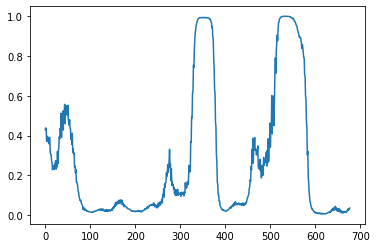